# RAPTOR-Style Hierarchical Summarization Demo

This notebook walks through a lightweight RAPTOR workflow over the long-form text in `themen_text.txt`. We will:

1. Split the document into manageable chunks.
2. Embed the chunks with OpenAI embeddings (no vector store needed).
3. Run PCA to project embeddings to 2D and visualize them.
4. Cluster the chunks, visualize the clusters, and summarize each cluster with an LLM.
5. Embed the summaries, cluster them again, and create a "summary of summaries" (the RAPTOR root).


## 0. Install dependencies (one-time)

Install the required packages with the following command if they are not already available in your environment.

In [1]:
!pip install -qU \
    langchain-openai \
    langchain-text-splitters \
    langchain-core \
    openai \
    matplotlib \
    seaborn \
    scikit-learn \
    pandas \
    numpy \
    python-dotenv


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.4 requires requests<3.0.0,>=2.32.5, but you have requests 2.32.4 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv
load_dotenv()


True

## 1. Environment & imports

Store your API keys securely via environment variables. The prompts below only run if a key is missing.

In [3]:
import getpass
import os

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")


In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate

sns.set_context("talk")

## 2. Load the source document

In [5]:
document_path = Path("themen_text.txt")
document = document_path.read_text(encoding="utf-8")
print(f"Loaded {document_path} with {len(document.split())} words")
document[:500]

Loaded themen_text.txt with 10011 words


"Football\n\nFootball, often described as humanity's most widely shared language, stretches far beyond the ninety minutes played on a rectangular pitch. The modern game draws roughly four billion fans who tune in for neighborhood derbies, continental tournaments, and late-night youth events staged under portable floodlights. Its roots lie in the informal matches of nineteenth-century industrial towns, yet it has evolved into a layered ecosystem that links village clubs to multinational leagues wort"

## 3. Split into chunks

We use the requested `RecursiveCharacterTextSplitter` with `chunk_size=100` and `chunk_overlap=0`.

In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=0)
chunks = text_splitter.split_text(document)
chunk_df = pd.DataFrame({"chunk_id": range(len(chunks)), "text": chunks})
chunk_df.head()

,chunk_id,text
0,0,Football
1,1,"Football, often described as humanity's most w..."
2,2,ninety minutes played on a rectangular pitch. ...
3,3,"tune in for neighborhood derbies, continental ..."
4,4,portable floodlights. Its roots lie in the inf...


## 4. Embed chunks (no vector store)

We use `text-embedding-3-large` via `OpenAIEmbeddings`. This cell may take a while depending on the number of chunks.

In [7]:
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")
chunk_vectors = np.array(embeddings_model.embed_documents(chunk_df["text"].tolist()))
chunk_vectors.shape

(857, 3072)

## 5. Dimensionality reduction with PCA

In [8]:
pca = PCA(n_components=2, random_state=42)
chunk_coords = pca.fit_transform(chunk_vectors)
chunk_df[["pc1", "pc2"]] = chunk_coords
chunk_df.head()

,chunk_id,text,pc1,pc2
0,0,Football,0.260327,0.297695
1,1,"Football, often described as humanity's most w...",0.222310,0.333270
2,2,ninety minutes played on a rectangular pitch. ...,0.198926,0.367033
3,3,"tune in for neighborhood derbies, continental ...",0.244652,0.361408
4,4,portable floodlights. Its roots lie in the inf...,0.212935,0.296502


### Visualization

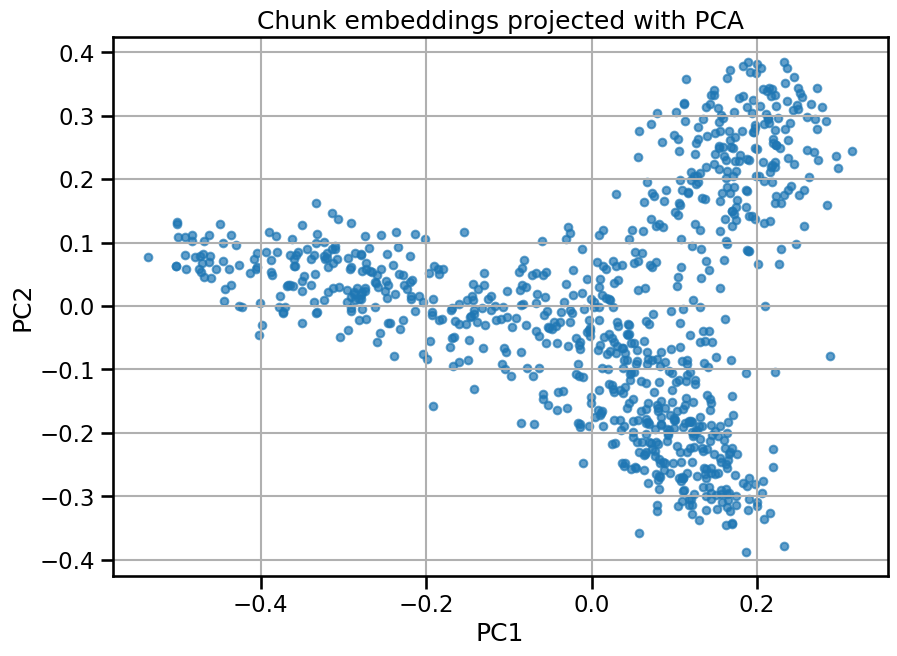

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(chunk_df["pc1"], chunk_df["pc2"], s=30, alpha=0.7)
plt.title("Chunk embeddings projected with PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Silhouette-Score

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def best_k_by_silhouette(X, k_min=2, k_max=15, random_state=42):
    scores = {}
    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        print(f"k={k}: silhouette={score:.4f}")
    # bestes k zurückgeben
    best_k = max(scores, key=scores.get)
    return best_k, scores

best_k, scores = best_k_by_silhouette(chunk_vectors, k_min=2, k_max=10)
print("Bestes k nach Silhouette:", best_k)

k=2: silhouette=0.0384
k=3: silhouette=0.0461
k=4: silhouette=0.0418
k=5: silhouette=0.0365
k=6: silhouette=0.0273
k=7: silhouette=0.0251
k=8: silhouette=0.0214
k=9: silhouette=0.0219
k=10: silhouette=0.0217
Bestes k nach Silhouette: 3


## 6. Clustering the chunks

We keep it simple with K-Means. Adjust `n_clusters` to taste.

In [19]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
chunk_df["cluster"] = kmeans.fit_predict(chunk_vectors)
chunk_df.groupby("cluster").size()

cluster
0    226
1    402
2    229
dtype: int64

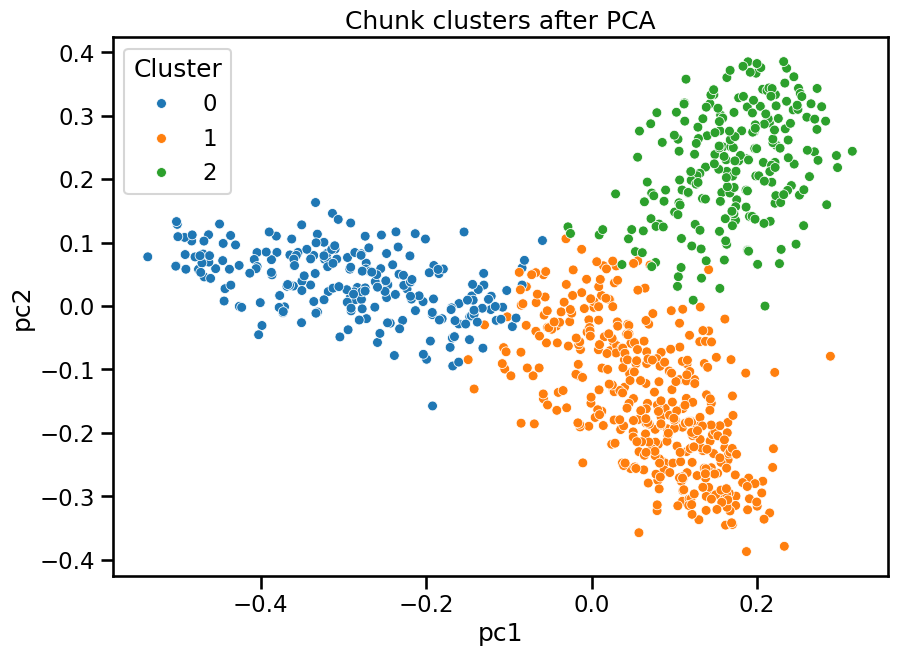

In [20]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=chunk_df,
    x="pc1",
    y="pc2",
    hue="cluster",
    palette="tab10",
    s=50,
)
plt.title("Chunk clusters after PCA")
plt.legend(title="Cluster")
plt.show()

## 7. Summarize each cluster with an LLM

The RAPTOR approach compresses each cluster into a higher-level node. We feed the concatenated chunk texts to a chat model and request a concise summary.

In [21]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You summarize thematic clusters of documents."),
    (
        "user",
        "Summarize the following cluster in <=150 words with a short title.\n\n{cluster_text}",
    ),
])

cluster_summaries = []

for cluster_id, group in chunk_df.groupby("cluster"):
    cluster_text = "\n\n".join(group["text"].tolist())
    response = llm.invoke(prompt.format_messages(cluster_text=cluster_text))
    cluster_summaries.append(
        {
            "cluster": int(cluster_id),
            "summary": response.content.strip(),
        }
    )

summary_df = pd.DataFrame(cluster_summaries).sort_values("cluster").reset_index(drop=True)
summary_df

,cluster,summary
0,0,**Title: The Interconnected Lives of Elephants...
1,1,**Title: Creative Resilience in Resource-Limit...
2,2,**The Global Impact of Football**\n\nFootball ...


## 8. Embed summaries and re-cluster

Now we re-embed the cluster summaries, reduce them with PCA, and run another round of clustering.

In [22]:
summary_vectors = np.array(embeddings_model.embed_documents(summary_df["summary"].tolist()))
summary_pca = PCA(n_components=2, random_state=42)
summary_coords = summary_pca.fit_transform(summary_vectors)
summary_df[["pc1", "pc2"]] = summary_coords

summary_clusters = min(3, len(summary_df))
summary_kmeans = KMeans(n_clusters=summary_clusters, random_state=42, n_init="auto")
summary_df["cluster_lvl2"] = summary_kmeans.fit_predict(summary_vectors)
summary_df

,cluster,summary,pc1,pc2,cluster_lvl2
0,0,**Title: The Interconnected Lives of Elephants...,-0.249557,0.559068,2
1,1,**Title: Creative Resilience in Resource-Limit...,-0.416909,-0.472707,0
2,2,**The Global Impact of Football**\n\nFootball ...,0.666466,-0.086361,1


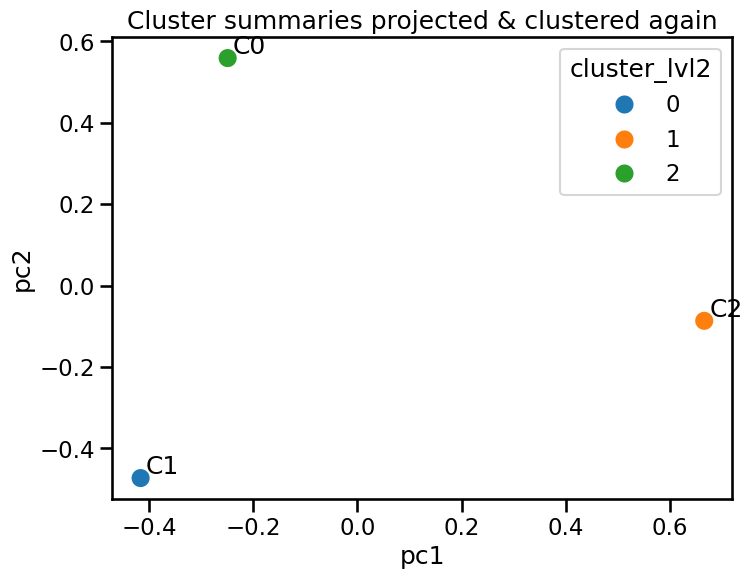

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary_df,
    x="pc1",
    y="pc2",
    hue="cluster_lvl2",
    palette="tab10",
    s=200,
)
for _, row in summary_df.iterrows():
    plt.text(row["pc1"] + 0.01, row["pc2"] + 0.01, f"C{row['cluster']}")

plt.title("Cluster summaries projected & clustered again")
plt.show()

## 9. Root summary (summary of summaries)

The final RAPTOR node combines the intermediate summaries into one high-level synopsis.

In [24]:
root_prompt = ChatPromptTemplate.from_messages([
    ("system", "You produce an executive summary that captures every cluster."),
    (
        "user",
        "Create a single coherent summary of these cluster summaries, highlighting major themes and transitions.\n\n{summaries}",
    ),
])

root_response = llm.invoke(
    root_prompt.format_messages(
        summaries="\n\n".join(
            f"Cluster {row.cluster}: {row.summary}" for row in summary_df.itertuples()
        )
    )
)
root_summary = root_response.content.strip()
root_summary

"**Executive Summary: Interconnected Themes of Ecology, Creativity, and Community through Elephants, Resource-Limited Environments, and Football**\n\nThis summary synthesizes three thematic clusters that explore the intricate relationships between ecological systems, community resilience, and cultural expressions, highlighting the interconnectedness of these domains in addressing contemporary challenges.\n\n**Cluster 0: The Interconnected Lives of Elephants and Their Ecosystems** emphasizes the critical role of elephants as ecological engineers, whose foraging and migratory behaviors shape their environments. The matriarchal structure of elephant societies, grounded in ancestral knowledge, underscores the importance of social bonds and communication, which are vital for conflict resolution and survival. Conservation efforts are increasingly recognizing the need to blend traditional knowledge with modern technology, fostering coexistence with human communities. Ethical considerations re